In [28]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np
from tqdm.notebook import tqdm

In [27]:
def get_bgr_frequencies(image):
    hist = {'red': [0] * 256, 'green': [0] * 256, 'blue': [0] * 256}
    for row in image:
        for pixel in row:
            hist['red'][pixel[2]] += 1
            hist['green'][pixel[1]] += 1
            hist['blue'][pixel[0]] += 1
    return hist

def get_hsi_frequencies(image):
    hist = {'hue': [0] * 360, 'saturation': [0] * 101, 'intensity': [0] * 101}
    for row in image:
        for pixel in row:
            hist['hue'][int(pixel[0])-1] += 1
            hist['saturation'][int(pixel[1] * 101)-1] += 1
            hist['intensity'][int(pixel[2] * 101)-1] += 1
    return hist

def plot_rgb_freq(freqs, save=False, save_path_name=None):
    plt.plot(freqs['red'], color='red',label='Red')
    plt.plot(freqs['green'], color='green',label='Green')
    plt.plot(freqs['blue'], color='blue',label='Blue')
    plt.show()
    if save:
        assert save_path_name is not None, "Please provide a name for the file"
        plt.savefig(save_path_name)


def plot_hsi_freq(freqs, save=False, save_path_name=None):

    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    cm_hue = plt.get_cmap('hsv')
    for i in range(256):
        ax1.bar(i, freqs['hue'][i], color=cm_hue(i/360))
    ax1.set_title('Hue')
    ax1.set_xticks(np.arange(0, 360, 18))

    for i in range(101):
        ax2.bar(i, freqs['saturation'][i], color='black')
        ax3.bar(i, freqs['intensity'][i], color='black')

    ax2.set_title('Saturation')
    ax2.set_xlabel('Saturation in 100 bins')
    ax2.set_ylabel('Frequency')

    ax3.set_title('Intensity')
    ax3.set_xlabel('Intensity in 100 bins')
    ax3.set_ylabel('Frequency')
    
    plt.show()
    if save:
        assert save_path_name is not None, "Please provide a name for the file"
        plt.savefig(save_path_name)
    plt.close()

def histo_mse(hist1, histo2):
    mse = 0
    for i in range(256):
        mse += (hist1['red'][i] - histo2['red'][i])**2
        mse += (hist1['green'][i] - histo2['green'][i])**2
        mse += (hist1['blue'][i] - histo2['blue'][i])**2
    return np.sqrt(mse)

def bgr_to_hsi(bgr_image):
    with np.errstate(divide='ignore', invalid='ignore'):
        B,G,R = np.squeeze(bgr_image[...,0]), np.squeeze(bgr_image[...,1]), np.squeeze(bgr_image[...,2])
        sum_rgb = R + G + B
        b,g,r = B/255, G/255, R/255

        I = (b + g + r) / 3
        indexes = sum_rgb != 0
        ri = r[indexes]
        gi = g[indexes]
        bi = b[indexes]

        H = np.zeros_like(I)
        H[indexes] = np.arccos(0.5 * (2*ri-gi-bi) / np.sqrt((ri-gi)**2 + (ri-bi)*(gi-bi)))
        H[(R == G) & (G == B)] = 0
        H = np.nan_to_num(H)
        bg_indexes = b>g
        H[bg_indexes] = 2*np.pi - H[bg_indexes]
        H = np.degrees(H)

        S = np.zeros_like(I)
        S[indexes] = (1 - np.minimum(np.minimum(ri,gi),bi)/I[indexes])

        return np.dstack((H,S,I))

def hsi_to_bgr(hsi_image):
    with np.errstate(divide='ignore', invalid='ignore'):
        H,S,I = np.squeeze(hsi_image[...,0]), np.squeeze(hsi_image[...,1]), np.squeeze(hsi_image[...,2])
        R,G,B = np.zeros_like(I), np.zeros_like(I), np.zeros_like(I)
        
        ind120 = H < 120
        ind240 = (H >= 120) & (H < 240)
        ind360 = H >= 240
        H = np.radians(H)
        
        B[ind120] = (I*(1-S))[ind120]
        R[ind120] = (I*(1+S*np.cos(H)/np.cos(np.pi/3-H)))[ind120]
        G[ind120] = (3*I-(R+B))[ind120]

        H[ind240] = (H-120)[ind240]
        R[ind240] = (I*(1-S))[ind240]
        G[ind240] = (I*(1+S*np.cos(H)/np.cos(np.pi/3-H)))[ind240]

        H[ind360] = (H-240)[ind360]
        G[ind360] = (I*(1-S))[ind360]
        B[ind360] = (I*(1+S*np.cos(H)/np.cos(np.pi/3-H)))[ind360]
        R[ind360] = (3*I-(G+B))[ind360]

        R,G,B = R*255, G*255, B*255
        return np.dstack((B,G,R)).astype('uint8')

def show_bgr_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
def get_gray_scale(bgr_image):
    return np.dot(bgr_image[...,:3], [0.299, 0.587, 0.114])

def is_frame_close(true_frame, test_frame, avg_threshold=1):
    diff = np.abs(true_frame - test_frame)
    return np.mean(diff) < avg_threshold

In [11]:
image_o = cv2.imread('./data/WSC sample.png')
image = image_o.copy()

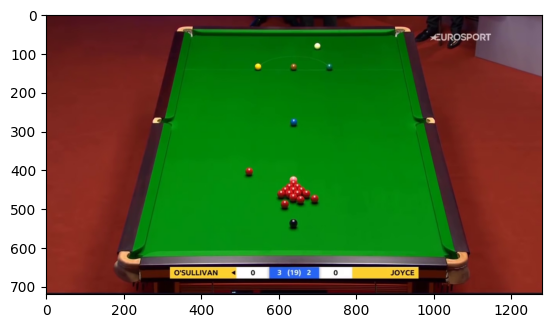

In [12]:
show_bgr_image(image)

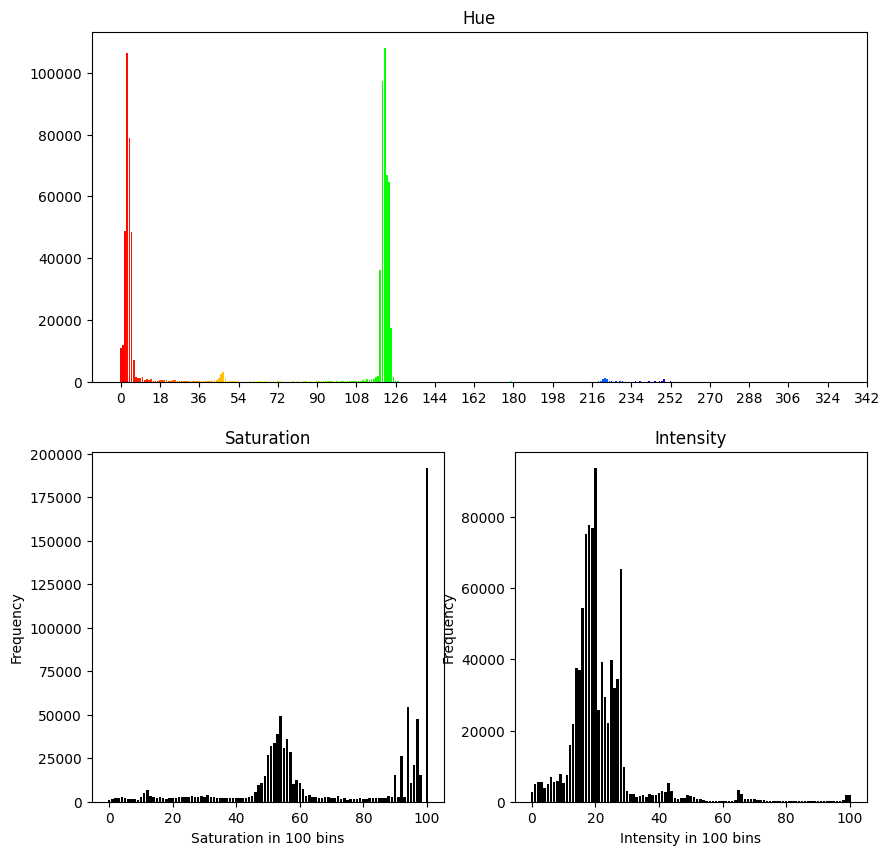

In [13]:
hsi_image = bgr_to_hsi(image)
hsi_freqs = get_hsi_frequencies(hsi_image)
plot_hsi_freq(hsi_freqs)

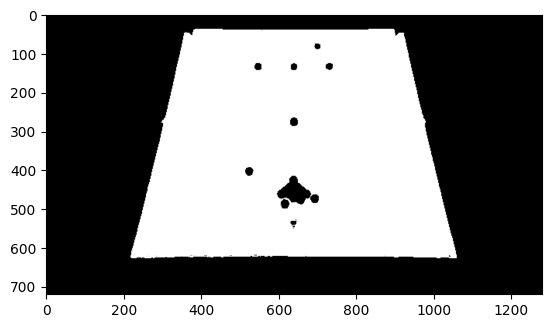

In [14]:
hue = hsi_image[...,0]
table = (hue > 100) & (hue < 130)
filtered = np.zeros_like(image)
filtered[table] = [255,255,255]
show_bgr_image(filtered)

In [18]:
first_frame = cv2.imread('./data/first frame.png')
first_frame_filtered =first_frame.copy()
first_frame_filtered[~table] = [0,0,0]
image_filtered = image.copy()
image_filtered[~table] = [0,0,0]
is_frame_close(image_filtered, first_frame_filtered)

65.79759403935185

In [19]:
video = cv2.VideoCapture('./data/WSC.mp4')

In [20]:
frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
frame_rate = video.get(cv2.CAP_PROP_FPS)
video_duration = frame_count / frame_rate
print(f"The video duration is {video_duration} seconds.")
# convert to hour, minutes seconds
video_duration = int(video_duration)
hours = video_duration // 3600
minutes = (video_duration % 3600) // 60
seconds = video_duration % 60
print(f"The video duration is {hours} hours, {minutes} minutes and {seconds} seconds.")

The video duration is 12262.6 seconds.
The video duration is 3 hours, 24 minutes and 22 seconds.


In [7]:
interesting_frames_timestaps = {
    0: {'hour': 0, 'minute': 16, 'second': 56 },
    1: {'hour': 0, 'minute': 17, 'second': 31 },
    2: {'hour': 0, 'minute': 28, 'second': 40 },
    3: {'hour': 0, 'minute': 29, 'second': 8 },
    4: {'hour': 0, 'minute': 29, 'second': 39 },
    5: {'hour': 0, 'minute': 29, 'second': 42 },
    6: {'hour': 0, 'minute': 59, 'second': 18 },
    7: {'hour': 2, 'minute': 51, 'second': 40 },
    8: {'hour': 2, 'minute': 39, 'second': 27 }   
}

for i, timestamp in interesting_frames_timestaps.items():
    video.set(cv2.CAP_PROP_POS_MSEC, (timestamp['hour']*3600 + timestamp['minute']*60 + timestamp['second'])*1000)
    ret, frame = video.read()
    cv2.imwrite(f'./data/interesting_frame_{i}.png', frame)

In [24]:
dist = {}
for i in range(9):
    test_frame = cv2.imread(f'./data/interesting_frame_{i}.png')
    test_frame[~table] = [0,0,0]
    dist[i] = is_frame_close(get_gray_scale(image_filtered), get_gray_scale(test_frame))
    cv2.putText(test_frame, f"Error: {dist[i]}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.imwrite(f'./data/interesting_frame_{i}_filtered.png', test_frame)
print(dist)

{0: 1.3067543891059021, 1: 0.860668962673611, 2: 2.775466866319445, 3: 0.5904960394965278, 4: 14.85328125, 5: 1.787783945312501, 6: 4.9686758387586805, 7: 4.020196752387152, 8: 8.860475402560764}


In [29]:
video = cv2.VideoCapture('./data/WSC.mp4')
frame_width = int(video.get(3))
frame_height = int(video.get(4))
fps = video.get(cv2.CAP_PROP_FPS)
out = cv2.VideoWriter('./data/WSC_filtered.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
true_table = ~table
filtered_gray_image = get_gray_scale(image_filtered)
# calculate number of frames
frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)


for i in tqdm(range(int(frame_count))):
    ret, frame = video.read()
    if ret:
        test_frame = frame.copy()
        test_frame[true_table] = [0,0,0]
        test_frame = get_gray_scale(test_frame)
        if is_frame_close(filtered_gray_image, test_frame, avg_threshold=1):
            out.write(frame)
    else:
        break
    
video.release()
out.release()

  0%|          | 0/367878 [00:00<?, ?it/s]

KeyboardInterrupt: 

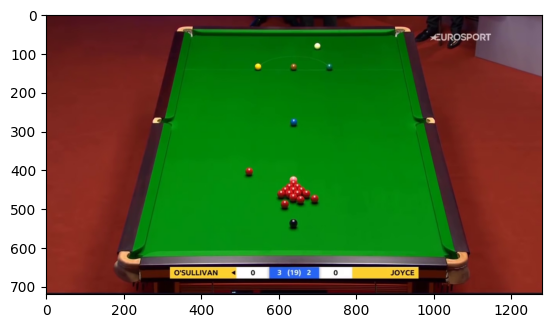

In [57]:
show_bgr_image(image)

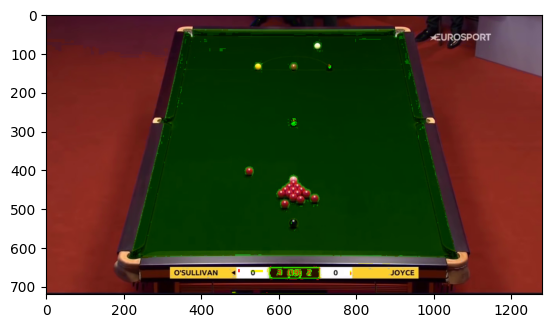

In [108]:
show_bgr_image(hsi_to_bgr(bgr_to_hsi(image)))